In [125]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("pastel") 

In [126]:
data = pd.read_csv('data/ds_salaries.csv')
data.head(1)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


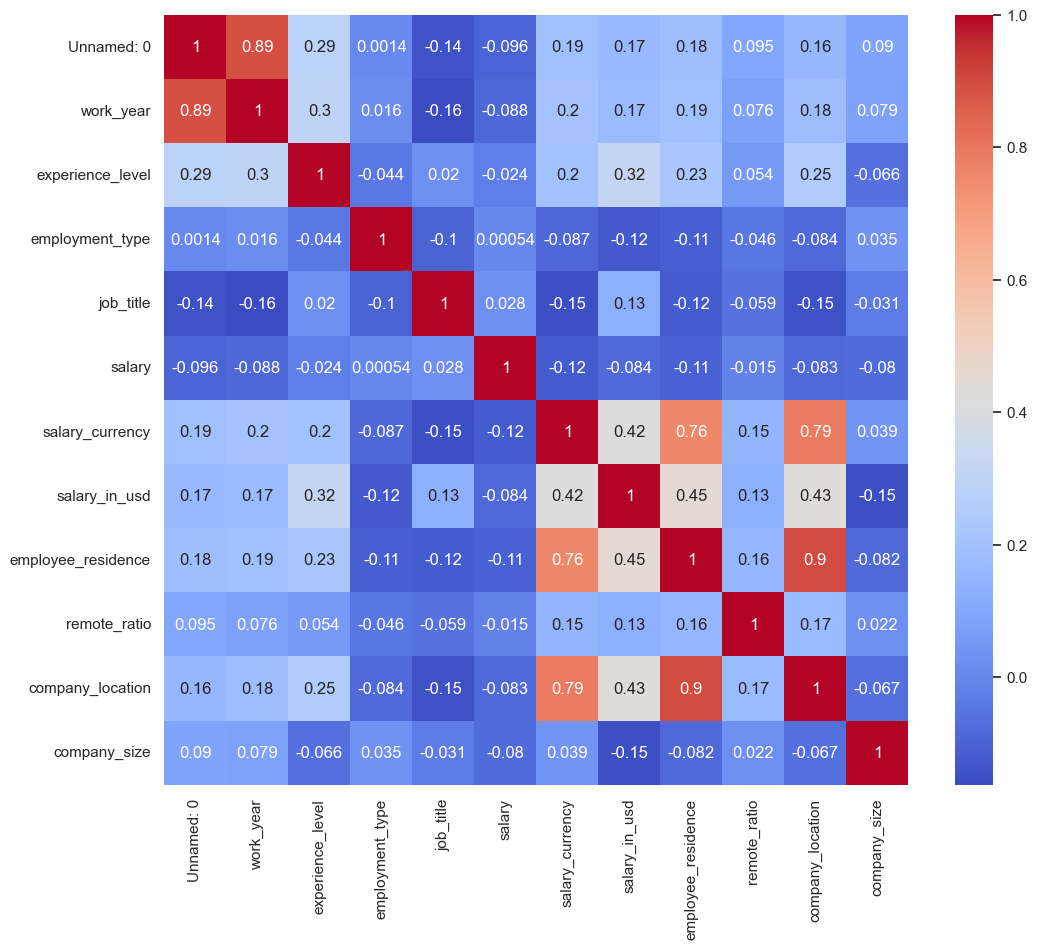

In [128]:
def plotting_heamap_corr(data):
    # Encoding categorical features to numerical
    label_encoders = {}
    for column in data.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

    correlation_matrix = data.corr()
    # Plotting heatmap correlation diagram
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

plotting_heamap_corr(data)

На первый взгляд, даже без визуального и углубленного анализа данных можно сделать вывод, что неифнормативные столбцы:
* Unnamed 0 - повторение индека(не несет никакой смысловой нагрузки)
* salary - У нас есть стандартизированная заработная плата в USD, следовательно, эта нам больше не нужна
* salary_currency - так как удаляем зарпату, то удаляем и валюту, по которой она рассчитывалась
* company_location - сильная связь с employee_residence(более важный для нас признак), так как мы исследуем зависимость ЗП людей, а не предложение компаний.

In [129]:
#data[data['employment_type'].value_counts(normalize=True).round(2) > 0.8].index

# Получаем категории, доля которых больше 80%
# high_freq_categories = data['employment_type'].value_counts(normalize=True).round(2)
# high_freq_categories = high_freq_categories[high_freq_categories > 0.8].index

# if not high_freq_categories.empty:
#     print('yes')
# else:
#     print('no')
high_freq_categories = []
for column in data.columns:
    freqency = data[column].value_counts(normalize=True)
    if not freqency[freqency > 0.9].empty:
        high_freq_categories.append(column)

display(high_freq_categories)   
#display(high_freq_categories)
# # Фильтрация строк, соответствующих этим категориям
# filtered_data = data[data['employment_type'].isin(high_freq_categories)]

# # Если нужен только индекс строк:
# filtered_indices = filtered_data.index

# display(filtered_indices)

['employment_type']

In [130]:
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employment_type'], axis=1)

In [131]:
data = data.drop_duplicates()

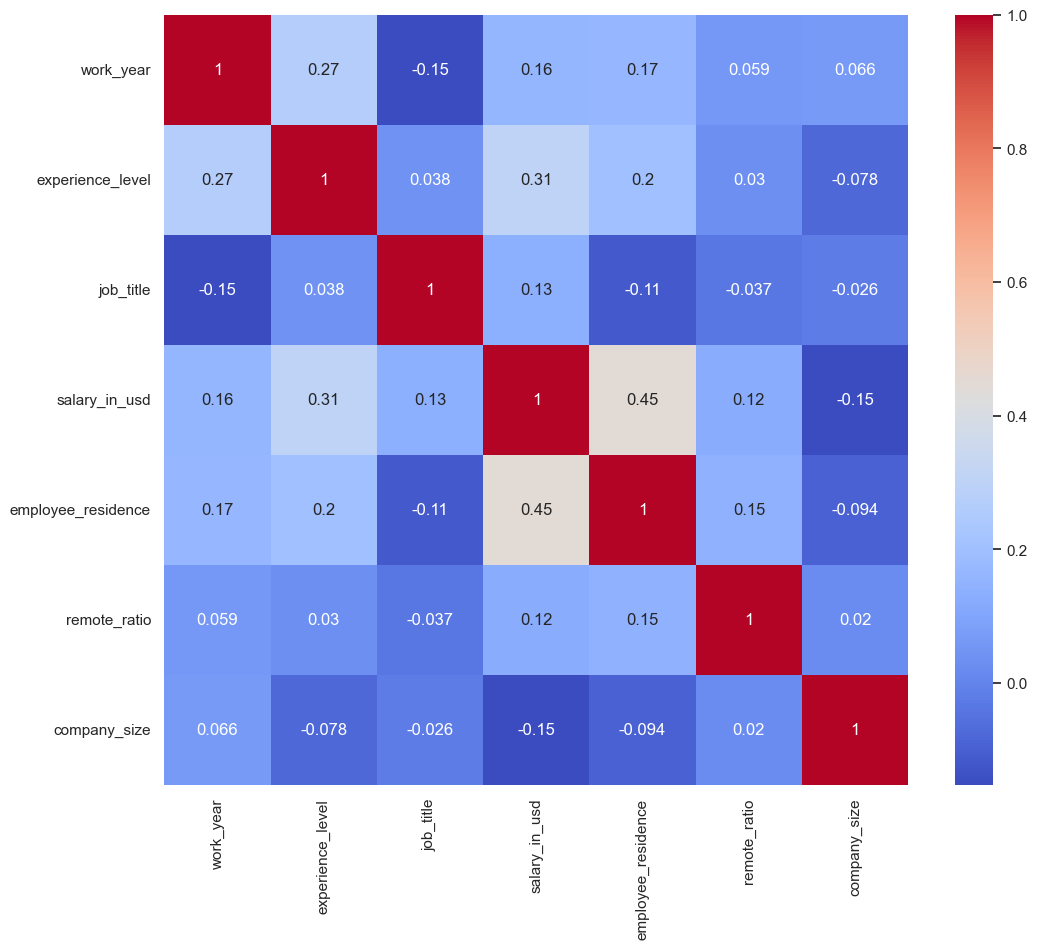

In [132]:
plotting_heamap_corr(data)

Из таблицы корреляции можно сказать, что у нас практически нет связи между переменными.

In [133]:
# data['work_year'].value_counts()

В данных все признаки являются категориальными, кроме:
* salary_in_usd - заработная плата в USD

Несмотря на то, что значения признака *remote_ratio* предсавлены числами, он является **категориальным**. Это связано с тем, что данный признак принимает значения-ярлыки, которые просто представляют разные уровни удаленной работы.
Тоже самое можно сказать признак *work_year* - он является **категориальным**. Потому что мы рассматриваем не временной промежутоки тенденции изменения от года к году, а просто 3 группы работников, которые получали зарплату за определенный год (2020, 2021, 2022)


In [134]:
data['remote_ratio'] = data['remote_ratio'].astype('object')
data['work_year'] = data['work_year'].astype('object')


Определим основные статистические характеристики

In [135]:
data.describe(include='all')

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_size
count,565.0,565.000000,565.000000,565.000000,565.000000,565.0,565.000000
unique,3.0,NaN,NaN,NaN,NaN,3.0,NaN
top,2022.0,NaN,NaN,NaN,NaN,100.0,NaN
freq,278.0,NaN,NaN,NaN,NaN,346.0,NaN
mean,NaN,2.072566,21.219469,110610.343363,39.684956,NaN,0.803540
std,NaN,1.046799,10.761171,72280.702792,18.382940,NaN,0.670018
min,NaN,0.000000,0.000000,2859.000000,0.000000,NaN,0.000000
25%,NaN,2.000000,15.000000,60757.000000,20.000000,NaN,0.000000
50%,NaN,2.000000,18.000000,100000.000000,55.000000,NaN,1.000000
75%,NaN,3.000000,22.000000,150000.000000,55.000000,NaN,1.000000


### Визуальный анализ данных

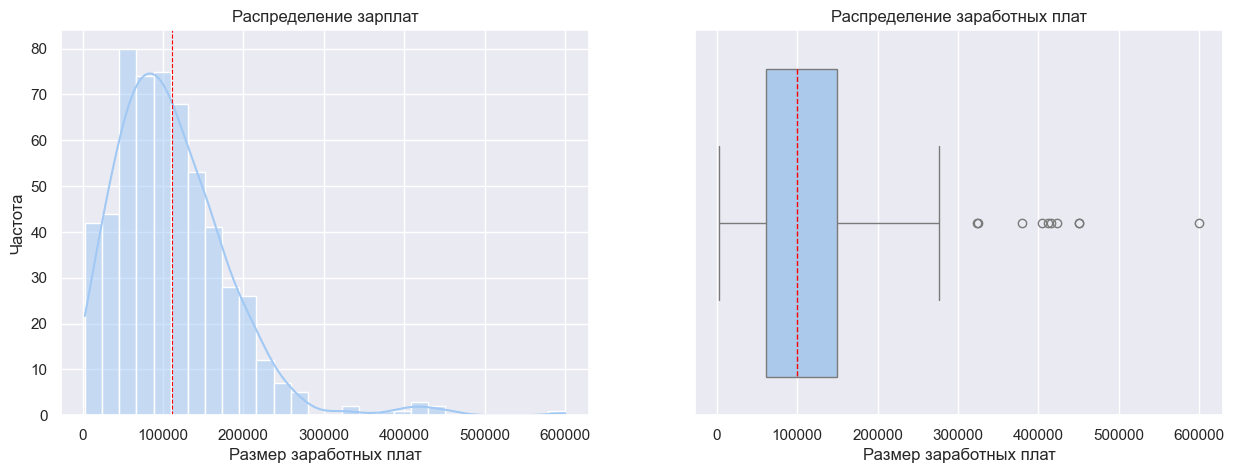

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработных плат', ylabel='Частота')
axes[0].set_title('Распределение зарплат')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})
axes[1].set(xlabel='Размер заработных плат')
axes[1].set_title('Распределение заработных плат')

plt.show()

In [137]:
shapiro_test = stats.shapiro(data['salary_in_usd'])
print(f'p_value = {round(shapiro_test.pvalue, 3)}')

if shapiro_test.pvalue <= 0.05:
    print('not a normal')
else:
    print('normal')

p_value = 0.0
not a normal


In [138]:
frequent_residences = data['employee_residence'].value_counts()[data['employee_residence'].value_counts() > 2].index.tolist()

data['employee_residence'] = data['employee_residence'].apply(lambda x: x if x in frequent_residences else 'other')
data['employee_residence'].value_counts()

employee_residence
55       295
other     44
20        43
27        30
8         27
14        24
19        18
18        15
21        12
32         7
46         6
43         6
7          6
40         5
30         4
44         4
49         4
0          3
2          3
56         3
53         3
3          3
Name: count, dtype: int64

In [139]:
# for column in data.columns:
#     if column not in ['salary_in_usd', 'job_title']:

#         plt.figure(figsize=(10, 4))
#         sns.countplot(y=column, data=data)
#         plt.title(f'Distribution of {column}')
#         plt.show()

In [140]:
# top_job_titles = data['job_title'].value_counts().nlargest(10)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="Blues_d")

# # Настройка графика
# plt.title('Top 10 Job Titles Distribution', fontsize=14)
# plt.xlabel('Count', fontsize=12)
# plt.ylabel('Job Title', fontsize=12)
# plt.tight_layout()

In [141]:
#
# # report = sv.analyze(data)
# # report.show_html()

In [142]:
profile = ProfileReport(data)
profile.to_file('Data_Science_analyze.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

d:\Course_for_DS\EDA_Statistics_test\env\Lib\site-packages\ydata_profiling\model\pandas\summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)
d:\Course_for_DS\EDA_Statistics_test\env\Lib\site-packages\ydata_profiling\model\pandas\summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [143]:
#data.info()

In [145]:
data.duplicated().sum()

np.int64(0)